# S&P 500 Machine learning Project

## Describe the data

In [2]:
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import datetime  # For date conversion 
import pandas_datareader.data as web #Web method to read data from web

import pandas as pd
import matplotlib.pyplot as plt # for plots
import seaborn as sns
import numpy as np
%matplotlib inline

In [3]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [4]:
sp500.index = pd.to_datetime(sp500.index)

In [5]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


### pattern visualization

<Axes: xlabel='Date'>

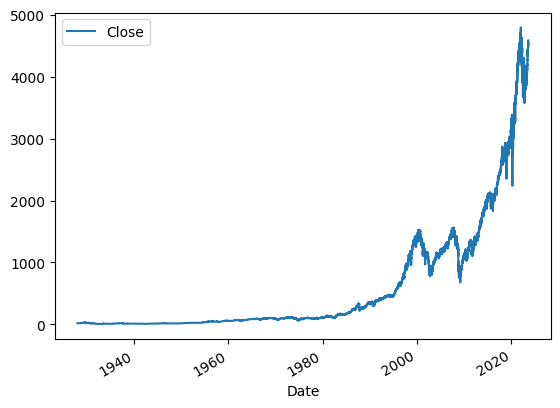

In [6]:
sp500.plot.line(y="Close", use_index=True)

### Data frame set up. Prediction target revolves around wether the price increased from a day closing to the next day closing (price increase marked with 1, otherwise marked with 0)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

### data description

In [11]:
# Data type check
sp500.dtypes

Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Tomorrow    float64
Target        int32
dtype: object

In [12]:
print("Describe Data")
sp500.describe()

Describe Data


,Open,High,Low,Close,Volume,Tomorrow,Target
count,8464.000000,8464.000000,8464.000000,8464.000000,8.464000e+03,8463.000000,8464.000000
mean,1549.380992,1558.619139,1539.516719,1549.703504,2.442738e+09,1549.844118,0.534381
std,1049.481466,1055.270833,1043.323820,1049.640699,1.852465e+09,1049.622992,0.498846
min,295.450012,301.450012,294.510010,295.459991,1.499000e+07,295.459991,0.000000
25%,889.772491,898.927521,878.932495,890.072479,6.260725e+08,890.194977,0.000000
50%,1261.940002,1269.885010,1254.184998,1261.940002,2.422605e+09,1261.989990,1.000000
75%,2010.630005,2020.982483,1995.749969,2011.292511,3.823648e+09,2011.315002,1.000000
max,4804.509766,4818.620117,4780.040039,4796.560059,1.145623e+10,4796.560059,1.000000


## Data analysis - We now investigate search for relevant predictors to use:

In [53]:
sp500.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Tomorrow    1
Target      0
dtype: int64

#### We see there's not much unassigned variables in our table so we can get rid such rows without practical influence later on

In [15]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', '^GSPC']
start = datetime.datetime(2015, 4, 9)
end = datetime.datetime(2020, 4, 9)

top4_df = pd.DataFrame()

# Call yfinance API to fetch data for Top 4 Tickers and S&P 500 for the date range between 2015 and 2020.
for ticker in tickers:
    try:
        df1 = yf.download(ticker, start=start, end=end)
        top4_df[ticker] = df1['Adj Close']
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# Also adding Date as a column
top4_df.insert(0, 'Date', top4_df.index)

# Rename S&P 500 column
top4_df.rename(columns={'^GSPC': 'S&P500'}, inplace=True)

top4_df.head()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,AAPL,MSFT,GOOGL,AMZN,S&P500
Date,,,,,,
2015-04-09,2015-04-09,28.509953,36.290344,27.400999,19.177000,2091.179932
2015-04-10,2015-04-10,28.631598,36.500309,27.427000,19.132500,2102.060059
2015-04-13,2015-04-13,28.575279,36.535309,27.431999,19.118000,2092.429932
2015-04-14,2015-04-14,28.451389,36.439064,26.989000,19.255501,2095.840088
2015-04-15,2015-04-15,28.559515,36.972748,27.052000,19.172501,2106.629883


#### Now let us now examine the correlation with other stocks 

## S&P 500 Prediction

In [19]:

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]


In [20]:
X_train, X_test, y_train, y_test = train[predictors],test[predictors], train["Target"], test["Target"]

### Find the best model to train our machine with:

In [21]:
rank_list = []
lr = LogisticRegression(max_iter = 10**6)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
rank_list.append({'model': 'LogisticRegression', 'score': lr_score})

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
rank_list.append({'model': 'RandomForestClassifier', 'score': rf_score})

In [23]:
svc = SVC()
svc.fit(X_train,y_train)
svc_score = svc.score(X_test, y_test)
rank_list.append({'model': 'SVC', 'score': svc_score})

In [24]:
# rank_list
sorted_rank_list = sorted(rank_list, key=lambda x: x['score'], reverse=True)
for i,mod in enumerate(sorted_rank_list):
    print(f"{i+1}. {mod['model']} - score: {mod['score'].round(3)}")

1. RandomForestClassifier - score: 0.59
2. LogisticRegression - score: 0.56
3. SVC - score: 0.56


In [26]:
from sklearn.metrics import precision_score

def score(model, model_name):
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)
    precision = precision_score(test["Target"], preds)
    print(f"{model_name}: {precision:.2f}")

In [27]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Support Vector Classifier": svc
}

In [28]:
scores = []

for model_name, model in models.items():
    score(model, model_name)
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)
    precision = precision_score(test["Target"], preds)
    scores.append((model_name, precision))

# Sort scores
scores.sort(key=lambda x: x[1], reverse=True)

print("\nScores sorted by high to low:")
for i, (model_name, precision) in enumerate(scores, start=1):
    print(f"{i}. {model_name}: {precision:.2f}")


Logistic Regression: 0.56
Random Forest: 0.64
Support Vector Classifier: 0.56

Scores sorted by high to low:
1. Random Forest: 0.64
2. Logistic Regression: 0.56
3. Support Vector Classifier: 0.56


### We see RandomForestClassifier is our best model

## Backtesting our model.

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [32]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [33]:
for model_name, model in models.items():
    predictions = backtest(sp500, model, predictors)
    prediction_counts = predictions["Predictions"].value_counts()
    precision = precision_score(predictions["Target"], predictions["Predictions"])
    target_distribution = predictions["Target"].value_counts() / predictions.shape[0]
    
    print(f"Model: {model_name}")
    print("Prediction Counts:\n", prediction_counts)
    print("Precision Score:", precision)
    print("Target Distribution:")
    for label, percentage in target_distribution.items():
        print(f"{label}: {percentage:.2%}")
    print("\n")


Model: Logistic Regression
Prediction Counts:
 Predictions
1    5964
Name: count, dtype: int64
Precision Score: 0.534037558685446
Target Distribution:
1: 53.40%
0: 46.60%


Model: Random Forest
Prediction Counts:
 Predictions
0    3429
1    2535
Name: count, dtype: int64
Precision Score: 0.5321499013806706
Target Distribution:
1: 53.40%
0: 46.60%


Model: Support Vector Classifier
Prediction Counts:
 Predictions
1    5139
0     825
Name: count, dtype: int64
Precision Score: 0.5333722514107803
Target Distribution:
1: 53.40%
0: 46.60%




## Optimizing and re-testing.

#### 1. Improve our prediction strategic to follow a pattern of predicting a result based on a rolling average of previous amount of days.
#### 2. Let the the predictors be represented as ratios (probabilities) instead of absolute price numbers.
#### 3. Get rid of noises - null/unassigned rows, rows with an outcome of success probability smaller than 60%.
#### 4. Optimise model execution arguments based on Trial&Error.

In [38]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500.loc[:, ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500.loc[:, trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]


In [39]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [40]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


In [41]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
lr = LogisticRegression(max_iter = 10**6)
svc = SVC(probability=True) 
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Support Vector Classifier": svc
}

In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    if hasattr(model, "predict_proba"):
        preds = model.predict_proba(test[predictors])[:, 1]
    else:  # For SVC, use decision_function
        preds = model.decision_function(test[predictors])
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [43]:
import warnings
for model_name, model in models.items():
    predictions = backtest(sp500, model, new_predictors)
    print(f"Model: {model_name}")
    print(predictions["Predictions"].value_counts())

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        precision = precision_score(predictions['Target'], predictions['Predictions'], zero_division=0)
        
    print(f"Precision Score: {precision}")
    print(predictions["Target"].value_counts() / predictions.shape[0])
    print("=" * 50)

Model: Logistic Regression
Predictions
0.0    4851
1.0     113
Name: count, dtype: int64
Precision Score: 0.5663716814159292
Target
1    0.543916
0    0.456084
Name: count, dtype: float64
Model: Random Forest
Predictions
0.0    4145
1.0     819
Name: count, dtype: int64
Precision Score: 0.568986568986569
Target
1    0.543916
0    0.456084
Name: count, dtype: float64
Model: Support Vector Classifier
Predictions
0.0    4964
Name: count, dtype: int64
Precision Score: 0.0
Target
1    0.543916
0    0.456084
Name: count, dtype: float64


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(predictions):
    accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
    precision = precision_score(predictions["Target"], predictions["Predictions"], zero_division=0)
    recall = recall_score(predictions["Target"], predictions["Predictions"])
    f1 = f1_score(predictions["Target"], predictions["Predictions"])
    return accuracy, precision, recall, f1


best_model = None
best_f1_score = 0.0

for model_name, model in models.items():
    predictions = backtest(sp500, model, new_predictors)
    accuracy, precision, recall, f1 = evaluate_model(predictions)
    
    print(f"Model: {model_name}")
    print(predictions["Predictions"].value_counts())
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("=" * 50)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model_name

best_model_info = f"The best model is: \033[1m{best_model}\033[0m with an F1-Score of {best_f1_score:.4f}"
print(best_model_info)


Model: Logistic Regression
Predictions
0.0    4851
1.0     113
Name: count, dtype: int64
Accuracy: 0.4591
Precision: 0.5664
Recall: 0.0237
F1-Score: 0.0455
Model: Random Forest
Predictions
0.0    4145
1.0     819
Name: count, dtype: int64
Accuracy: 0.4788
Precision: 0.5690
Recall: 0.1726
F1-Score: 0.2648
Model: Support Vector Classifier
Predictions
0.0    4964
Name: count, dtype: int64
Accuracy: 0.4561
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
The best model is: Random Forest with an F1-Score of 0.2648


#### Create a visualization using Seaborn to compare the evaluation metrics (Accuracy, Precision, Recall, and F1-Score) of the models

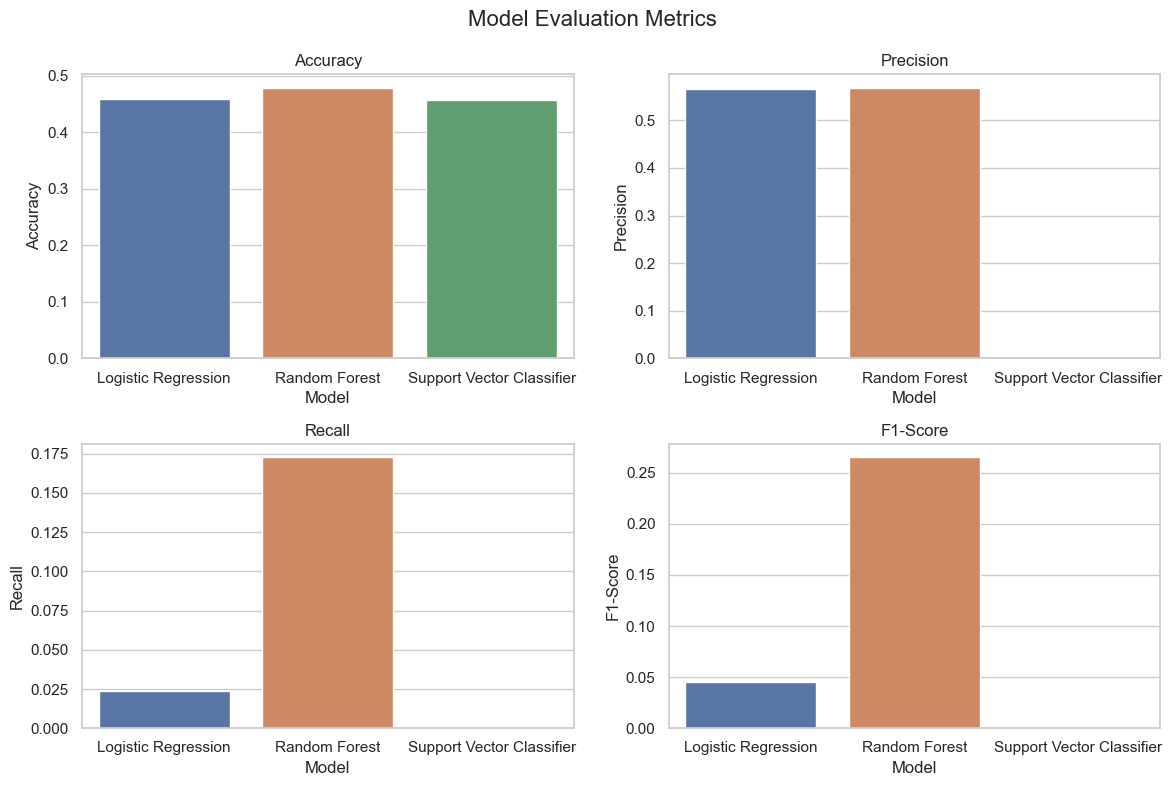

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (your existing code for model evaluation)

# Create a list to store the metrics for each model
metrics_data = []

for model_name, model in models.items():
    predictions = backtest(sp500, model, new_predictors)
    accuracy, precision, recall, f1 = evaluate_model(predictions)
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert the metrics data into a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Set up Seaborn style
sns.set(style="whitegrid")

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Model Evaluation Metrics", fontsize=16)

# Plot the metrics using Seaborn
sns.barplot(x="Model", y="Accuracy", data=metrics_df, ax=axes[0, 0])
axes[0, 0].set_title("Accuracy")

sns.barplot(x="Model", y="Precision", data=metrics_df, ax=axes[0, 1])
axes[0, 1].set_title("Precision")

sns.barplot(x="Model", y="Recall", data=metrics_df, ax=axes[1, 0])
axes[1, 0].set_title("Recall")

sns.barplot(x="Model", y="F1-Score", data=metrics_df, ax=axes[1, 1])
axes[1, 1].set_title("F1-Score")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


In [46]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,0.0
2003-11-18 00:00:00-05:00,1,0.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,0.0
...,...,...
2023-08-01 00:00:00-04:00,0,0.0
2023-08-02 00:00:00-04:00,0,0.0
2023-08-03 00:00:00-04:00,0,0.0


## Epilogue. More methods to improve our predictors.

### Let's explore the influence of the Top 4 stocks on the S&P 500 index and investigate their correlation with each other.

Text(0.5, 1.0, 'Top 4 Stocks Correlation with S&P 500')

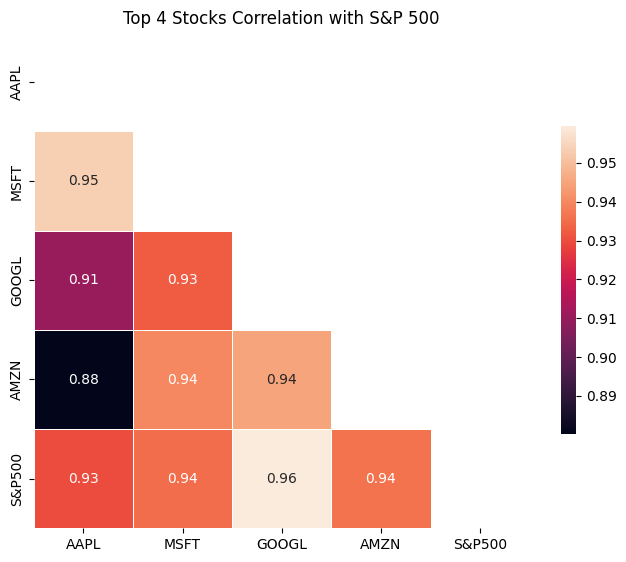

In [16]:
# Calculate correlation matrix
corr = top4_df.drop(columns=['Date']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, annot=True, 
            cbar_kws={"shrink": .5})
ax.set_title('Top 4 Stocks Correlation with S&P 500')


#### The correlation graph above reveals a robust correlation between the S&P 500 stock and the other stocks. This suggests a high degree of synchronicity in the movements of these individual stocks with the S&P 500.

### Returns - S&P 500 and Big 4

#### The rate of return indicates the percentage gained or lost over a specific time frame. This calculation is performed using the following formula:

#### **Rate of Return % = (Current Price - Starting Price) / Starting Price * 100**

#### We will visualize the annual returns of the top 5 major stocks and compare them to the S&P 500's performance over the past five years.

Text(0.5, 1.0, 'Big 5 stocks and S&P 500 Returns in last 5 Years')

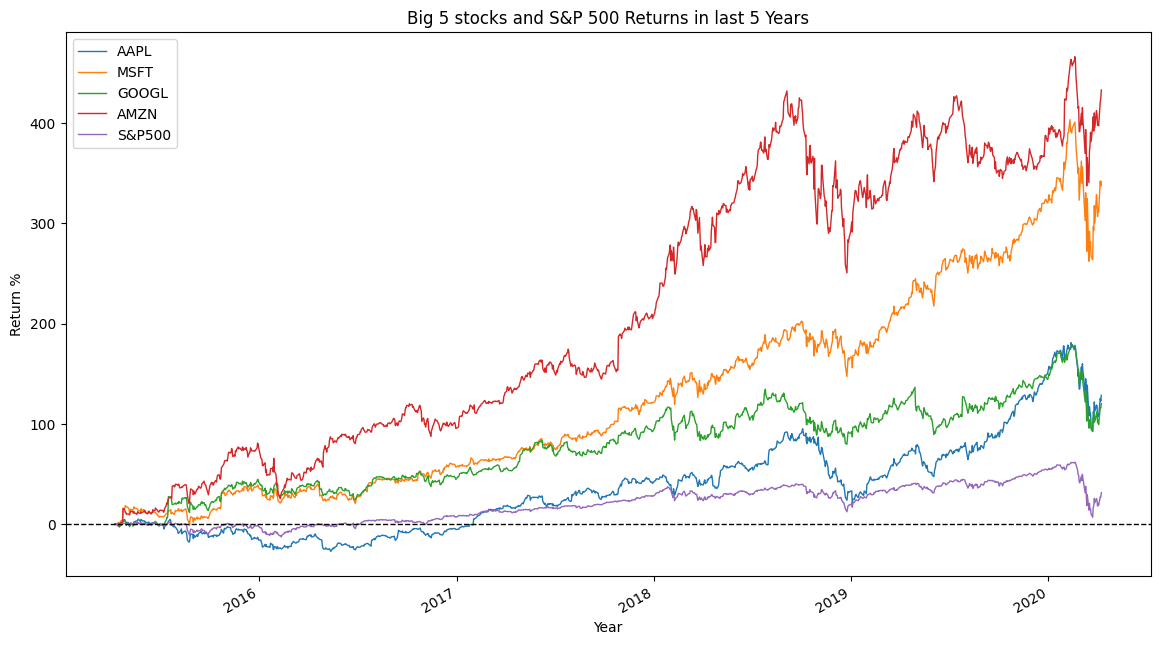

In [17]:
top4_df_dup = top4_df.copy() # make a copy of the close dataframe to make changes

# Removing date field 
top4_df_dup = top4_df_dup.drop(['Date'],axis=1)

# Calculating a Simple return
top4_df_dup = (top4_df_dup - top4_df_dup.iloc[0, :])/top4_df_dup.iloc[0, :]*100 

# plot the rate of return over time
top4_df_dup.plot(legend=True, figsize=(14, 8), linewidth=1)
plt.axhline(y=0, linestyle='dashed', color='black', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Return %')
plt.title('Big 5 stocks and S&P 500 Returns in last 5 Years')